In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [37]:
class DSO:
	def __init__(self, totalHours, marginalCost, unitSalePrice, maxPriceReference):
		self.totalHours = totalHours
		self.numberOfAggregators = 0
		self.marginalCost = marginalCost
		self.unitSalePrice = unitSalePrice
		self.maxPriceReference = maxPriceReference
		self.aggregators = []
		self.maxUtility = 0
		self.m = 0

	def addAggregator(self, aggregator):
		self.aggregators.append(aggregator)
		self.numberOfAggregators = self.numberOfAggregators + 1

	def getAggregators(self):
		return self.aggregators

	def Sfunction(self, aggregator, tIndex):
		return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))
	
	def CostFunction(self, tIndex):
		return self.marginalCost[tIndex]
	
	def getLeftLimit(self):
		leftLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.maximumDemand[i] / agg.nominalDemand[i])))
			leftLimit[i] = mx
		return leftLimit
	
	def getRightLimit(self):
		rightLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.minimumDemand[i] / agg.nominalDemand[i])))
			rightLimit[i] = mx
		return rightLimit
	
	def getUnitSalePriceRange(self):
		minPrice = self.marginalCost
		leftLimit = self.getLeftLimit()
		minPrice = np.minimum(minPrice, leftLimit)

		maxPrice = self.maxPriceReference
		rightLimit = self.getRightLimit()
		maxPrice = np.maximum(maxPrice, rightLimit)

		return minPrice, maxPrice

	def generateUnitSalePrice(self):
		minPrice, maxPrice = self.getUnitSalePriceRange()
		for i in range(self.totalHours):
			self.unitSalePrice[i] = random.uniform(minPrice[i], maxPrice[i])

	def generateM(self):
		m = 0
		mx = 0
		for i in range(self.totalHours):
			sum = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				sum = sum + agg.bestLoadResponse[i]
			mx = max(mx, sum)
		m = random.uniform(mx, mx*10)
		self.m = m

	def utilityFunction(self, theta, omega):
		# generated usp and m

		# store value of INT_MIN in mx
		mx = -1000000000000
		for j in range(self.totalHours):
			sum = 0
			for i in range(self.numberOfAggregators):
				agg = self.aggregators[i]
				sum = sum + self.unitSalePrice[j] * agg.bestLoadResponse[j] - self.CostFunction(j) * agg.bestLoadResponse[j] + omega * self.Sfunction(agg, j)
			sum = sum - theta*self.m
			mx = max(mx, sum)
		return mx

	def getPAR(self):
		# sum of all bestResponses for each hour for each aggregator
		sum = 0
		for i in range(self.totalHours):
			for j in range(self.numberOfAggregators):
				sum = sum + self.aggregators[j].bestLoadResponse[i]
		return (self.m * self.totalHours) / (sum)

class Aggregator:
	def __init__(self, totalHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction):
		self.totalHours = totalHours
		self.nominalDemand = nominalDemand
		self.minimumDemand = minimumDemand
		self.maximumDemand = maximumDemand
		self.maxPriceReference = maxPriceReference
		self.preferenceSatisfaction = preferenceSatisfaction
		self.currentUtility = 0
		self.bestLoadResponse = [0 for i in range(totalHours)]

	def utilityFunction(self, DSO):
		sum = 0
		for i in range(DSO.totalHours):
			sum = sum + DSO.Sfunction(self, i) - (DSO.unitSalePrice[i] * self.bestLoadResponse[i])
		return sum

	def optimalDR(self, DSO, j):
		self.bestLoadResponse[j] = ((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference) / DSO.unitSalePrice[j])))

In [38]:
datasetPath = '../dataset/'

In [39]:
numOfLA = 3
numOfHours = 50

In [40]:
nominalDemands = []
for i in range (0, 3):
	letter = chr(ord('A') + i)
	fileName = 'Home' + letter + '_hourly.csv'
	df = pd.read_csv(datasetPath + fileName)
	df = df[0:numOfHours]
	# Power is in kW
	nominalDemands.append(df['Power'].tolist())

In [41]:
LAs = []
# maxPriceReference = 30
maxPriceReference = 100
for i in range(numOfLA):
	nominalDemand = nominalDemands[i]
	# find max of nominalDemand
	maxNominalDemand = max(nominalDemand)
	minimumDemand = np.random.uniform(0.0001, nominalDemand, numOfHours)
	maximumDemand = np.random.uniform(nominalDemand, maxNominalDemand+1, numOfHours)
	preferenceSatisfaction = np.random.uniform(0.1, 15, numOfHours)
	LAs.append(Aggregator(numOfHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction))


In [42]:
# # print all the values for each LA
# for i in range(numOfLA):
# 	print("LA", i)
# 	print("nominal demand: ", LAs[i].nominalDemand)
# 	print("minimum demand: ", LAs[i].minimumDemand)
# 	print("maximum demand: ", LAs[i].maximumDemand)
# 	print("max price reference: ", LAs[i].maxPriceReference)
# 	print("preference satisfaction: ", LAs[i].preferenceSatisfaction)

In [43]:
marginalCost = np.random.randint(1, 7, numOfHours) # cent/kW
unitSalePrice = np.random.randint(1, 7, numOfHours) # cent/kWh
dso = DSO(numOfHours, marginalCost, unitSalePrice, maxPriceReference)

In [44]:
# append all the LAs to the DSO
for i in range(numOfLA):
	dso.addAggregator(LAs[i])

In [45]:
# # print all the values for the DSO
# print("DSO")
# print("marginal cost: ", dso.marginalCost)
# print("unit sale price: ", dso.unitSalePrice)

In [46]:
# for each aggregator, find the optimal DR for each hour
for i in range(numOfLA):
	agg = LAs[i]
	for j in range(numOfHours):
		agg.optimalDR(dso, j)

In [47]:
# generate unit sale price for the DSO
dso.generateUnitSalePrice()

In [48]:
# generate m for the DSO
dso.generateM()

In [49]:
# utility function for the DSO
theta = 0.5
omega = 0.5
print("utility function: ", dso.utilityFunction(theta, omega))

utility function:  5401.461055886568


In [50]:
# print Unit Sale Price
print("Unit Sale Price: ", dso.unitSalePrice)

Unit Sale Price:  [671  15   6  91 195  74  26  22  37  94  11  52  93 288   0 378 108 133
  96  29 661  66  35   1 170 213  23  41  66  77 144  14  44  29  70 129
 827  82  96   6 148 368  69  54 253 331  72   7   8  21]


omega : weight factor for customer satisfaction

theta : weight factor for peak demand

m : peak demand > max of sum of load at all times

In [51]:
# print utility for each house
for i in range(numOfLA):
	print("LA", i)
	ut = LAs[i].utilityFunction(dso)
	print("utility: ", ut)

LA 0
utility:  1917.8571734162267
LA 1
utility:  8228.17025995864
LA 2
utility:  782.427015103987


In [52]:
dso.getPAR()

34.876690662024

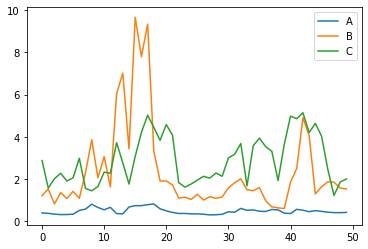

In [53]:
# plot nominal demand of each LA
for i in range(numOfLA):
	plt.plot(LAs[i].nominalDemand)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)])
plt.show()

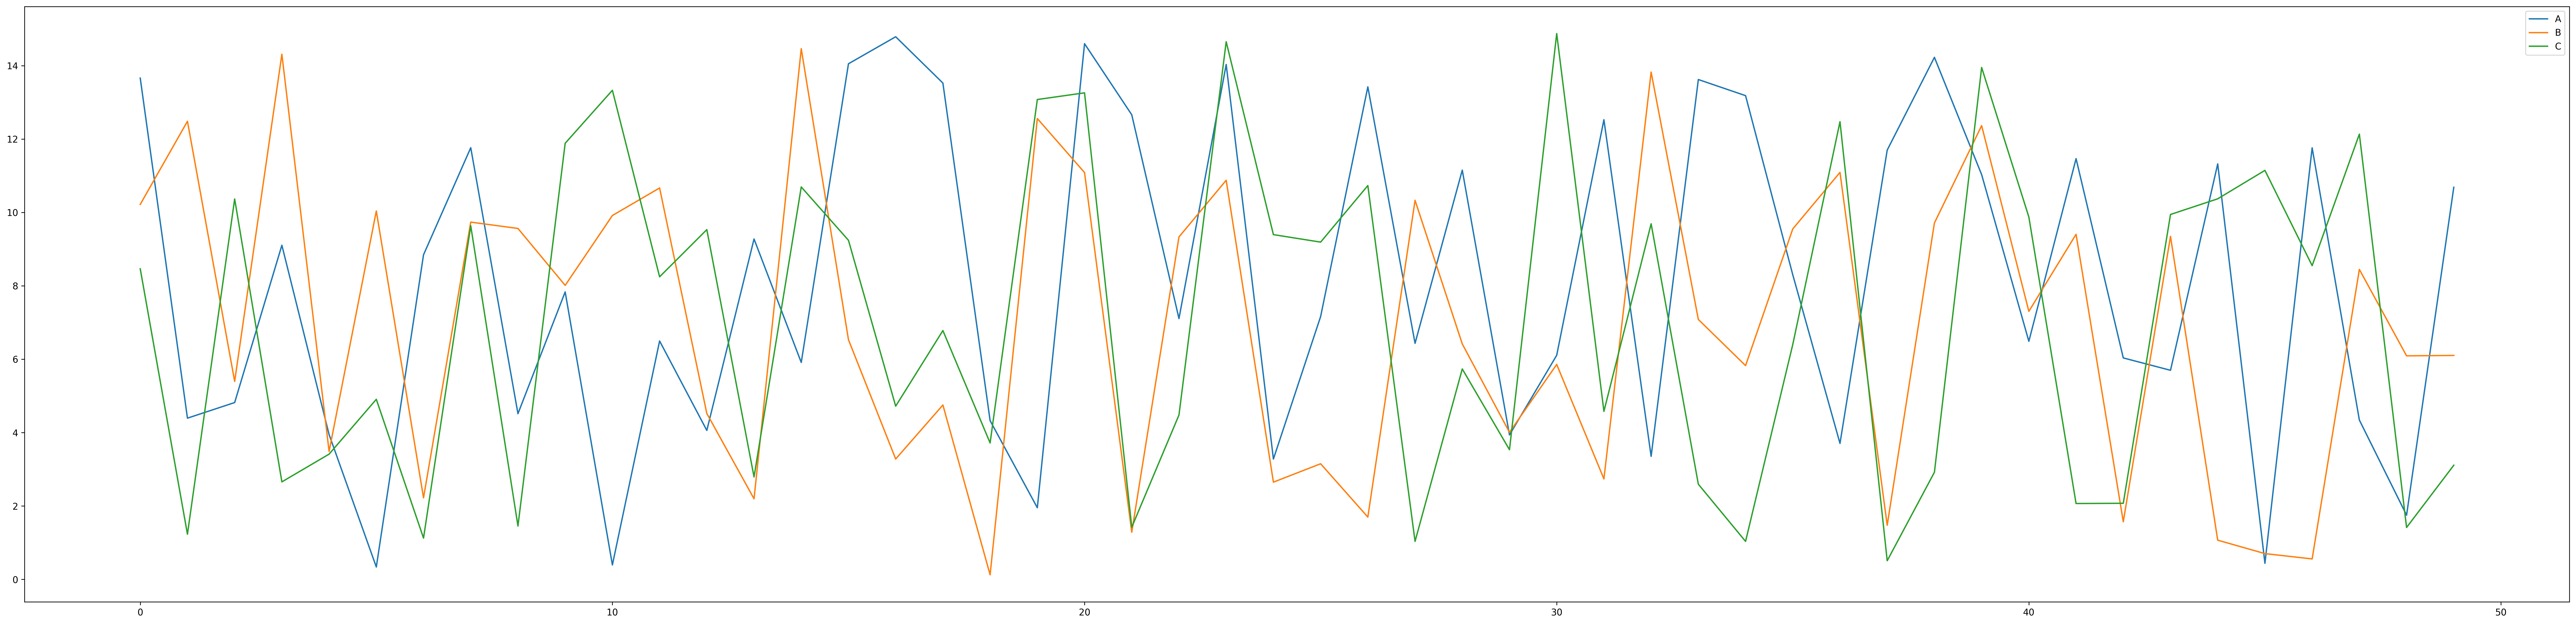

In [54]:
# plot user pref of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].preferenceSatisfaction)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)])
plt.show()

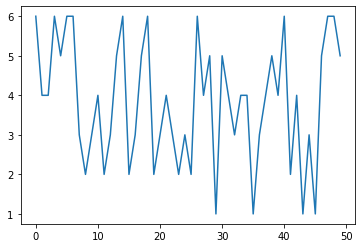

In [55]:
# plot marginal cost
plt.plot(dso.marginalCost)
plt.show()

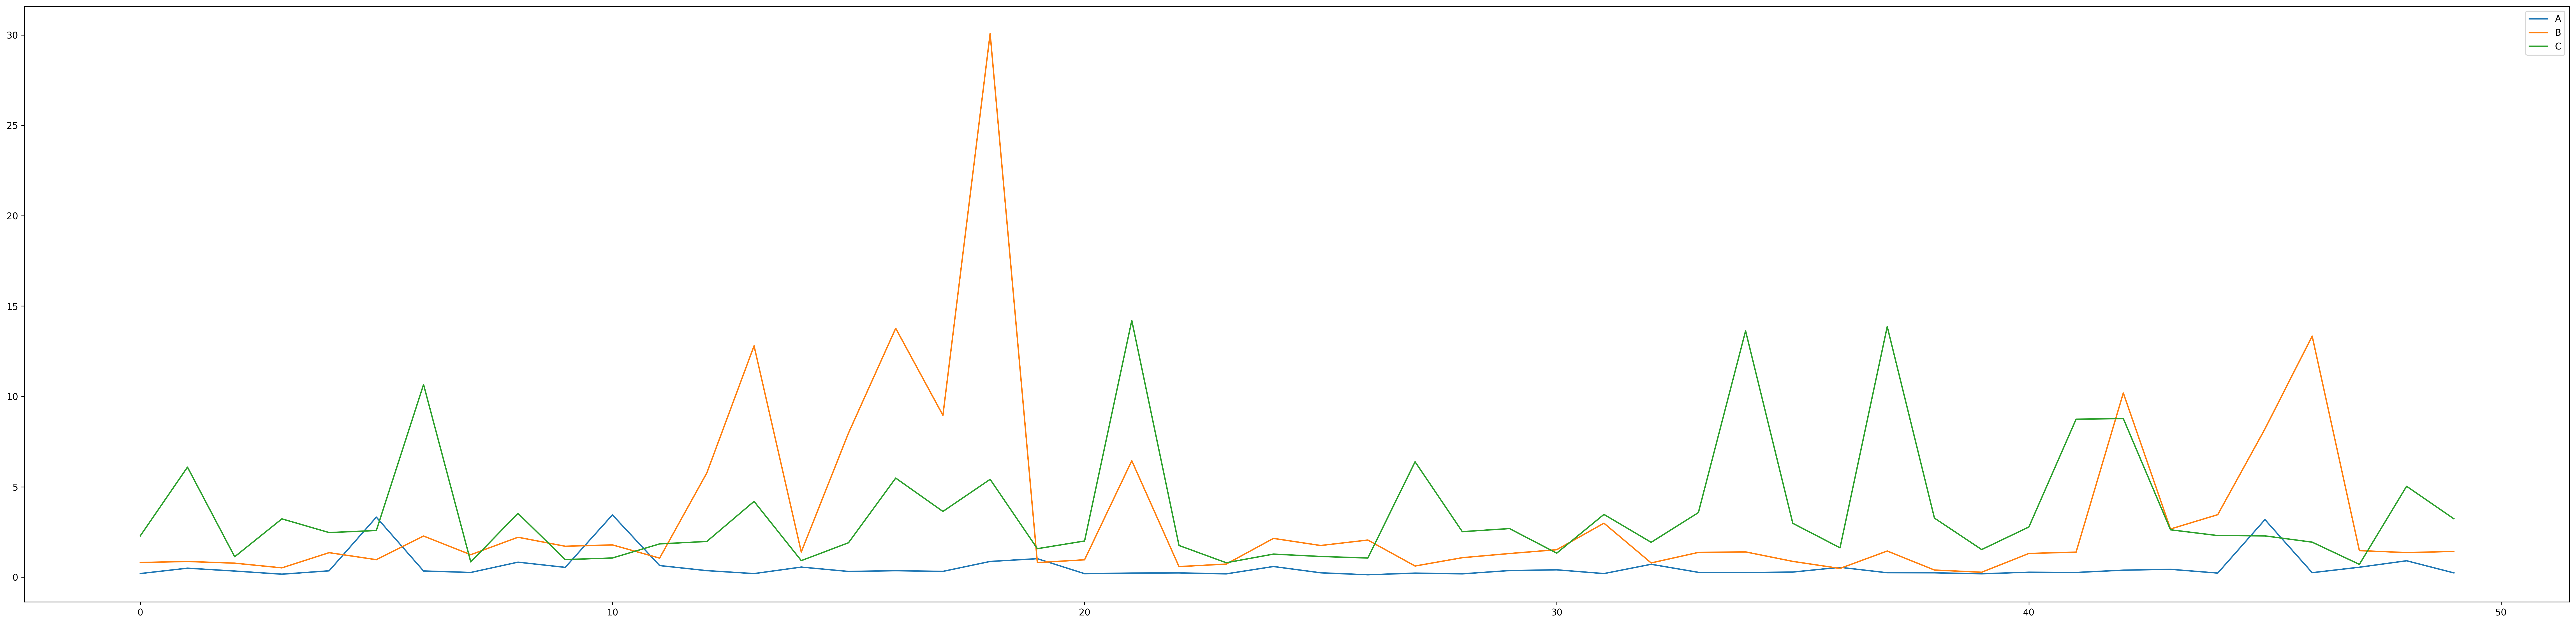

In [56]:
# plot bestLoadResponse of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].bestLoadResponse)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)])
plt.show()

In [60]:
# # save the variables for each LA
# for i in range(numOfLA):
# 	letter = chr(ord('A') + i)
# 	fileName = 'Home' + letter + '_hourly.csv'
# 	df = pd.read_csv(datasetPath + fileName)
# 	df = df[0:numOfHours]
# 	df['nominalDemand'] = LAs[i].nominalDemand
# 	df['minimumDemand'] = LAs[i].minimumDemand
# 	df['maximumDemand'] = LAs[i].maximumDemand
# 	df['preferenceSatisfaction'] = LAs[i].preferenceSatisfaction
# 	df['bestLoadResponse'] = LAs[i].bestLoadResponse
# 	df.to_csv(datasetPath + 'Home' + letter + '_hourly_results.csv', index=False)

In [61]:
# # save the variables for the DSO
# df = pd.DataFrame()
# df['marginalCost'] = dso.marginalCost
# df['unitSalePrice'] = dso.unitSalePrice
# df['PAR'] = dso.getPAR()
# df.to_csv(datasetPath + 'DSO_hourly_results.csv', index=False)